## 데이콘 구내식당 식수 인원 예측 AI 경진대회
####  MAE (평균절대오차)가 평가 지표! 

In [88]:
import numpy as np 
import pandas as pd 
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from nltk import word_tokenize, sent_tokenize
import nltk
import datetime
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

warnings.filterwarnings('ignore')

In [89]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# 데이터 삽입

In [90]:
train_df= pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

sub = pd.read_csv('sample_submission.csv')

Test 데이터는 train 데이터와 동일한 변수들이 있으나, 중식계와 석식계가 빠져있음

        -> 중식계와 석식계가 예측 대상인 타겟이기 때문
        -> Train 데이터로 학습을 진행하고, test 데이터로 중식계와 석식계의 값을 예측한 csv 파일을 만들어 제출할 것

# EDA 및 데이터 전처리

### 요일 전처리

In [91]:
# object형인 요일을 수치형 변수로. 월요일부터 차례로 1, 2, 3, 4, 5로 매핑

train_df['요일']=train_df['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})
train_df.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [92]:
# test 데이터도 똑같이

test_df['요일']=test_df['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})
test_df.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,3,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,4,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,5,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021-02-01,1,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021-02-02,2,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치


In [93]:
# '일자‘ 변수가 datetime형이 아닌 object형
# 일자를 datetime형으로 바꿔주고, 일자에서 연 / 월 / 일 데이터를 뽑아 각각 변수로 저장

train_df['일자']=pd.to_datetime(train_df['일자'])
test_df['일자']=pd.to_datetime(test_df['일자'])

train_df['연']=train_df['일자'].dt.year
train_df['월']=train_df['일자'].dt.month
train_df['일']=train_df['일자'].dt.day

test_df['연']=test_df['일자'].dt.year
test_df['월']=test_df['일자'].dt.month
test_df['일']=test_df['일자'].dt.day

In [94]:
train_df.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,연,월,일
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016,2,1
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2016,2,2
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2016,2,3
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2016,2,4
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2016,2,5


'출근자수'변수 생성

In [95]:
# 파생 변수 생성 
# 본사정원수에서 본사휴가자수, 현본사소속재택근무자수, 본사출장자수를 뺀 "출근자수"라는 변수
# 이 변수를 통해 실제로 회사에 출근한 인원, 즉 "실제 식수 가능 인원"이 얼마인지 알 수 있음

train_df['출근자수']=train_df['본사정원수']-train_df['본사휴가자수']-train_df['현본사소속재택근무자수']-train_df['본사출장자수']
test_df['출근자수']=test_df['본사정원수']-test_df['본사휴가자수']-test_df['현본사소속재택근무자수']-test_df['본사출장자수']

공휴일 전날에는 휴가를 내지 않더라도 구내식당에서 석식을 먹고 싶어하지 않을 것
    
    -> 식수 인원 줄어들 것
    -> 공휴일 전날을 1, 다른 날을 0으로 인코딩하여 ‘공휴일전날’이라는 이름의 변수 생성
    -> "공휴일전날"이라는 변수를 만들어 0으로 초기화해준 후, 공휴일 전날에 해당하는 데이터를 찾아 그 데이터만 1로 변환

"공휴일전날"변수 생성

In [96]:
train_df.head(18)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,연,월,일,출근자수
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016,2,1,2401.0
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2016,2,2,2378.0
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2016,2,3,2365.0
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2016,2,4,2277.0
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2016,2,5,2142.0
5,2016-02-11,4,2601,383,143,417,0.0,팬케익/찐빵 우유/두유/주스 계란후라이 견과류죽/쌀밥 (쌀:국내산) 감자찌개 ...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 시래기국 훈제오리구이 도토리묵무침 쌈무/양...","참치회덮밥 (쌀,현미흑미:국내산) 맑은국 군만두 과일샐러드 락교 포기김치 (...",1045.0,550.0,2016,2,11,2075.0
6,2016-02-12,5,2601,389,156,93,0.0,모닝롤/야채샌드 우유/두유/주스 계란후라이 고구마죽/쌀밥 (쌀:국내산) 봄동된...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치콩나물국 미니함박 어묵볶음 물파래무침 ...",909.0,598.0,2016,2,12,2056.0
7,2016-02-15,1,2601,87,204,482,0.0,모닝롤/치즈프레즐 우유/두유/주스 계란후라이 잣죽/쌀밥 (쌀:국내산) 민물새우...,쌀밥/잡곡밥 (쌀:국내산) 시금치국 닭감자조림 (닭고기:국내산) 연두부*양념장 ...,"쌀밥/잡곡밥 (쌀:국내산) 홍합미역국 등갈비김치찜 (돼지고기,김치:국내산) 임연수...",1268.0,672.0,2016,2,15,2310.0
8,2016-02-16,2,2601,72,236,526,0.0,모닝롤/마늘빵 우유/두유/주스 계란후라이 단호박죽/쌀밥 (쌀:국내산) 어묵국 ...,쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국 (쇠고기:호주산) 탕수어 (동태:러시아산) 오...,쌀밥/잡곡밥 (쌀:국내산) 된장찌개 쇠불고기 (쇠고기:호주산) 해파리겨자채 봄동...,1014.0,523.0,2016,2,16,2293.0
9,2016-02-17,3,2601,78,250,23,0.0,모닝롤/참치샌드 우유/두유/주스 계란후라이 흑임자죽/쌀밥 (쌀:국내산) 북어계...,쌀밥/잡곡밥 (쌀:국내산) 냉이된장국 쇠고기장조림 (쇠고기:호주산) 통도라지구이 ...,볶음밥*자장소스 (쌀:국내산) 맑은국 새우또띠아 쨔샤이무침 요플레 포기김치 ...,916.0,588.0,2016,2,17,2273.0


In [97]:
train_df['공휴일전날']=0    # '공휴일전날'변수 초기화
test_df['공휴일전날']=0   

In [98]:
train_df['공휴일전날'][4]=1 #'16 설연휴
train_df['공휴일전날'][17]=1 #삼일절
train_df['공휴일전날'][47]=1 #국회의원 선거
train_df['공휴일전날'][62]=1 #어린이날
train_df['공휴일전날'][67]=1 #석가탄신일
train_df['공휴일전날'][152]=1 #추석연휴
train_df['공휴일전날'][245]=1 #'17 설연휴
train_df['공휴일전날'][264]=1 #'17 삼일절
train_df['공휴일전날'][309]=1 # 석가탄신일
train_df['공휴일전날'][310]=1 #'17 어린이날
train_df['공휴일전날'][330]=1 #'17 현충일
train_df['공휴일전날'][379]=1 #'17 광복절
train_df['공휴일전날'][502]=1 #'18 설연휴
train_df['공휴일전날'][510]=1 #'18 삼일절
train_df['공휴일전날'][552]=1 #'18 근로자의 날
train_df['공휴일전날'][555]=1 #'18 어린이날
train_df['공휴일전날'][565]=1 #'18 석가탄신일
train_df['공휴일전날'][575]=1 #'18 현충일
train_df['공휴일전날'][579]=1 #'18 지방선거
train_df['공휴일전날'][623]=1 #'18 광복절
train_df['공휴일전날'][650]=1 #'18 추석연휴
train_df['공휴일전날'][651]=1 #'18 한글날
train_df['공휴일전날'][705]=1 #'18 성탄절
train_df['공휴일전날'][709]=1 #'19 신정
train_df['공휴일전날'][732]=1 #'19 설연휴
train_df['공휴일전날'][748]=1 #'19 삼일절
train_df['공휴일전날'][790]=1 #'19 근로자의 날
train_df['공휴일전날'][814]=1 #'19 현충일
train_df['공휴일전날'][863]=1 #'19 광복절
train_df['공휴일전날'][882]=1 #'19 추석연휴
train_df['공휴일전날'][894]=1 #'19 개천절
train_df['공휴일전날'][897]=1 #'19 한글날
train_df['공휴일전날'][951]=1 #'19 성탄절
train_df['공휴일전날'][955]=1 #'20 신정
train_df['공휴일전날'][971]=1 #'20 설연휴
train_df['공휴일전날'][995]=1 #'20 삼일절
train_df['공휴일전날'][1027]=1 #'20 국회의원선거
train_df['공휴일전날'][1037]=1 #'20 석가탄신일
train_df['공휴일전날'][1038]=1 #'20 어린이날
train_df['공휴일전날'][1061]=1 #'20 현충일
train_df['공휴일전날'][1099]=1 #'20 광복절
train_df['공휴일전날'][1129]=1 #'20 추석연휴
train_df['공휴일전날'][1133]=1 #'20 한글날
train_df['공휴일전날'][1187]=1 #'20 성탄절

train_df['공휴일전날'][1215]=1 #'21 설연휴
train_df['공휴일전날'][1225]=1 #'21 삼일절

조식/중식/석식 메뉴 체크

        조식, 중식, 석식의 메뉴에 어떤 메뉴가 자주 나오는지 확인하고자 함

        먼저 '밥, 우유, 김치' 등과 같이  기본적인 제공 메뉴들을 'word'라는 변수로 받아
        이를 제외하고 메뉴를 살펴봄.


In [99]:
breakfast2=[]; lunch2=[]; dinner2=[]     # 리스트 생성

def bld(temp,word):
    for t in temp:
        if word in t:
            temp.remove(t)
    return temp

word=['(',')', '밥','김치','국','찌개','나물']

for i in range(1205) :                       
    b=train_df.iloc[i]['조식메뉴'].split()               ## string을 나눠 list로 저장
    l=train_df.iloc[i]['중식메뉴'].split()
    d=train_df.iloc[i]['석식메뉴'].split()
    for w in word:
        b=bld(b,w); l=bld(l,w); d=bld(d,w)              ## word에 있는 메뉴=b에 있는 메뉴 이면 b에서 그 변수 제외시킴
    breakfast2.append(b); lunch2.append(l); dinner2.append(d)

train_df['breakfast2']=breakfast2; train_df['lunch2']=lunch2 ; train_df['dinner2']=dinner2   ## 제외된 메뉴들 컬럼 생성

가장 많이 나오는(top-k개) 메뉴를 리스트 형태로 받아 출력하는 함수 menu_lot을 만듦

In [100]:
def various_menu(meal):         # meal 자리에 breakfast2, lunch2, dinner2 들어감
    menu=[]                     # breakfast2에 있는 메뉴들을 menu에 넣고 카운트
    count=[]                    # 메뉴와 개수가 같이 리스트로 menu에 저장
    for m in meal:
            for mm in m:
                if mm not in menu:
                    menu.append(mm) 
                    count.append(1) # count 마지막에 1을 추가
                else:
                    i=menu.index(mm)  ## mm  이 있는 위치 인덱스를 i로
                    count[i] +=1
    return menu, count     #[menu,count]   
    

# 가장 많이 나오는 n개 메뉴 확인

def menu_lot(n, menu_bld):
    menu=menu_bld[0]; count=menu_bld[1]
    top_idx=np.argsort(count)[-n:]               # 내림차순 정렬 큰 수부터
    top_count=[count[i] for i in top_idx]
    top_values=[menu[i] for i in top_idx]
    print(top_count)
    print(top_values)
    return top_count , top_values

조식/중식/석식 별로 많이 나오는 메뉴를 확인해 봄.

        -> 그 결과 가장 많이 나오는 메뉴가 어떤 특별한 메뉴로 보이지는 않음.


In [101]:
menu_breakfast = various_menu(breakfast2)
b= menu_lot(30, menu_breakfast)[1]
print('')

menu_lunch = various_menu(lunch2)
l= menu_lot(30, menu_lunch)[1]
print('')

menu_dinner = various_menu(dinner2)
d= menu_lot(30, menu_dinner)[1]
print('')

[27, 27, 28, 29, 30, 32, 33, 33, 34, 35, 39, 40, 40, 40, 41, 41, 42, 42, 42, 43, 43, 44, 45, 46, 52, 53, 114, 241, 911, 1172]
['모닝롤/햄치즈샌드', '꽈리고추찜', '멸치볶음', '모닝롤/꿀호떡', '우유/두유/주스', '미역줄기볶음', '모닝롤/바나나샌드', '모닝롤/토마토샌드', '모닝롤/고구마파이', '모닝롤/치즈프레즐', '모닝롤/베이글', '모닝롤/단팥빵', '명엽채무침', '모닝롤/씨크립샌드', '모닝롤/와플', '모닝롤/야채샌드', '모닝롤/참치샌드', '김구이', '진미채무침', '모닝롤/에그샌드', '꽃게탕', '모닝롤/찐빵', '모닝롤/크로와상', '모닝롤/마늘빵', '모닝롤/프렌치토스트', '김자반', '양상추샐러드', '스크램블에그', '계란후라이', '우유/주스']

[17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 22, 23, 23, 24, 24, 24, 24, 25, 25, 27, 28, 29, 30, 32, 35, 62, 95]
['고추잡채*꽃빵', '골뱅이무침*소면', '시금치프리타타', '닭볶음탕', '우엉잡채', '도토리묵무침', '주꾸미볶음', '감자채볶음', '마늘쫑무침', '메추리알조림', '어묵볶음', '육개장', '아삭고추무침', '언양식불고기', '요구르트', '제육볶음', '계란찜', '짬뽕불고기', '무생채', '새송이버섯전', '꽃게탕', '돈육굴소스볶음', '훈제오리구이', '계란말이', '버섯불고기', '닭갈비', '오징어볶음', '오이무침', '깍두기', '배추겉절이']

[15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 18, 19, 19, 20, 20, 21, 22, 23, 23, 23, 25, 26, 29, 30, 31, 32, 33, 35, 81]
['고등어구이', '키위드레싱샐러드', '아삭고추무침', '닭갈비', '오이

석식계가 0인 값 처리

    
> 석식계가 0인 날은 대부분 수요일 -> 매달 마지막 주 수요일은 자기계발의 날로 석식계가 0 임 


In [102]:
train_df[train_df['석식계']==0]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,연,월,일,출근자수,공휴일전날,breakfast2,lunch2,dinner2
204,2016-11-30,3,2689,68,207,0,0.0,모닝롤/카스텔라 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 고추장찌개 ...,나물비빔밥 (쌀:국내산) 가쯔오장국 치킨핑거*요거트D 감자샐러드 오복지무침 ...,*,1109.0,0.0,2016,11,30,2414.0,0,"[모닝롤/카스텔라, 우유/주스, 스크램블에그, 김자반]","[치킨핑거*요거트D, 감자샐러드, 오복지무침]",[*]
224,2016-12-28,3,2705,166,225,0,0.0,모닝롤/고구마파이 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 북어계란국 ...,콩나물밥 (쌀:국내산) 가쯔오장국 미트볼케찹조림 꽃맛살샐러드 군고구마 배추겉...,*,767.0,0.0,2016,12,28,2314.0,0,"[모닝롤/고구마파이, 우유/주스, 스크램블에그, 느타리호박볶음]","[미트볼케찹조림, 꽃맛살샐러드, 군고구마, 배추겉절이]",[*]
244,2017-01-25,3,2697,79,203,0,0.0,모닝롤/토마토샌드 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 ...,카레덮밥 (쌀:국내산) 맑은국 유린기 개성감자만두 오이사과무침 포기김치 (김...,*,720.0,0.0,2017,1,25,2415.0,0,"[모닝롤/토마토샌드, 우유/주스, 계란후라이, 김자반]","[유린기, 개성감자만두, 오이사과무침]",[*]
262,2017-02-22,3,2632,75,252,0,0.0,모닝롤/브라우니 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 꽃게탕 명엽채...,나물비빔밥 (쌀:국내산) 유부장국 생선까스*탈탈소스 파스타샐러드 마늘쫑볶음 ...,*,1065.0,0.0,2017,2,22,2305.0,0,"[모닝롤/브라우니, 우유/주스, 계란후라이, 꽃게탕, 명엽채무침]","[생선까스*탈탈소스, 파스타샐러드, 마늘쫑볶음]",[*]
281,2017-03-22,3,2627,53,235,0,0.0,모닝롤/찐빵 우유/주스 계란후라이 김치죽/쌀밥 (쌀:국내산) 콩나물국 김실파무침...,쌀밥/잡곡밥 (쌀:국내산) 돈육김치찌개 유린기 비엔나볶음 세발나물 깍두기 (...,*,953.0,0.0,2017,3,22,2339.0,0,"[모닝롤/찐빵, 우유/주스, 계란후라이, 김실파무침]","[유린기, 비엔나볶음, 깍두기]",[*]
306,2017-04-26,3,2626,45,304,0,0.0,모닝롤/와플 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 된장찌개 검정콩조...,비빔밥 (쌀:국내산) 맑은국 오징어튀김 견과류조림 하와이안샐러드 깍두기 (김...,*,835.0,0.0,2017,4,26,2277.0,0,"[모닝롤/와플, 우유/주스, 계란후라이, 검정콩조림]","[오징어튀김, 견과류조림, 하와이안샐러드, 깍두기]",[*]
327,2017-05-31,3,2637,43,265,0,0.0,모닝롤/베이글 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 자...,열무보리비빔밥 (쌀:국내산) 가쯔오장국 탕수만두 콥샐러드 오이지무침 포기김치...,자기계발의날,910.0,0.0,2017,5,31,2329.0,0,"[모닝롤/베이글, 우유/주스, 계란후라이, 자반김]","[탕수만두, 콥샐러드, 오이지무침]",[자기계발의날]
346,2017-06-28,3,2648,58,259,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 쇠고기매운국 고...,콩나물밥 (쌀:국내산) 얼갈이된장국 삼치구이 잡채 아삭고추무침 깍두기 (김치...,*자기계발의날*,745.0,0.0,2017,6,28,2331.0,0,"[모닝롤/단팥빵, 우유/주스, 계란후라이]","[삼치구이, 잡채, 아삭고추무침, 깍두기]",[*자기계발의날*]
366,2017-07-26,3,2839,254,246,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 민물새우찌개 숙...,나물비빔밥 미소장국 파스타샐러드 소세지오븐구이 오렌지 포기김치 (김치:국내산),가정의날,797.0,0.0,2017,7,26,2339.0,0,"[모닝롤/단팥빵, 우유/주스, 계란후라이]","[파스타샐러드, 소세지오븐구이, 오렌지]",[가정의날]
392,2017-09-01,5,2642,177,303,45,0.0,모닝롤/단팥빵 우유/주스 계란후라이 단호박죽/쌀밥 (쌀:국내산) 대구찌개 깻순나...,쌀밥/잡곡밥 (쌀:국내산) 시래기국 훈제오리구이 두부구이*양념장 쌈무/양파절임...,*,663.0,0.0,2017,9,1,2162.0,0,"[모닝롤/단팥빵, 우유/주스, 계란후라이]","[훈제오리구이, 두부구이*양념장, 쌈무/양파절임]",[*]


In [103]:
## 2020년부터 마지막 주 수요일이 자기계발의 날이 아니었음 
## 따라서 석식계가 0인 날을 이상치로 복 전주의 같은 요일의 석식계로 값을 대체

train_df['석식계']=train_df['석식계'].replace(0, np.NaN)     ## 석식계 0인 걸 null값으로 처리
yoil=train_df['요일'].unique()                              ## 유니크한 요일 변수들을 yoil에 저장

print(yoil)

dfs={y:train_df[train_df['요일']==y] for y in yoil}         ## 각 요일에 해당하는 train_df 값을 dfs에 저장

for y in yoil :
    dfs[y]['석식계']=dfs[y]['석식계'].fillna(method='ffill')

train_df1=pd.concat(dfs)
train_df1=train_df1.droplevel(0)                         ## 0 index나 컬럼 삭제
train_df1=train_df.sort_index()
train_df1.head()

[1 2 3 4 5]


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,연,월,일,출근자수,공휴일전날,breakfast2,lunch2,dinner2
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016,2,1,2401.0,0,"[모닝롤/찐빵, 우유/두유/주스, 계란후라이, 쥐어채무침]","[쇠불고기, 계란찜, 청포묵무침, 요구르트]","[육개장, 자반고등어구이, 두부조림, 건파래무침]"
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2016,2,2,2378.0,0,"[모닝롤/단호박샌드, 우유/두유/주스, 계란후라이, 시래기조림]","[가자미튀김, 모둠소세지구이, 마늘쫑무침, 요구르트, 배추겉절이]","[유산슬, 아삭고추무침, 바나나]"
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2016,2,3,2365.0,0,"[모닝롤/베이글, 우유/두유/주스, 계란후라이, 느타리호박볶음]","[치킨핑거, 쫄면야채무침, 견과류조림, 요구르트]","[황태양념구이, 고기전, 새송이버섯볶음]"
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2016,2,4,2277.0,0,"[모닝롤/토마토샌드, 우유/두유/주스, 계란후라이, 멸치볶음]","[주꾸미볶음, 부추전, 요구르트]","[우동, 멕시칸샐러드, 군고구마, 무피클]"
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2016,2,5,2142.0,1,"[모닝롤/와플, 우유/두유/주스, 계란후라이]","[돈육씨앗강정, 우엉잡채, 청경채무침, 요구르트]","[닭갈비, 감자소세지볶음]"


## 외부데이터 - 기상청 진주 날씨

-> LH본사가 위치한 진주의 날씨 데이터를 가져와 구내 식당 식수 예측에 유의미한 영향을 주는지 알아봄


-> climate 데이터 삽입

https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&openPopup=Y

기상청 진주시 날씨 - 강수량 , 최고온도 


2016-02-01 ~~ 2020-04-09

In [104]:
climate =pd.read_csv("진주시기상자료.csv", encoding='cp949')   
climate.head(15)

,지점,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm)
0,192,진주,2016-02-01,-0.6,-4.1,5.0,NaN
1,192,진주,2016-02-02,-2.3,-9.1,6.2,NaN
2,192,진주,2016-02-03,-1.7,-9.3,7.7,NaN
3,192,진주,2016-02-04,-0.2,-7.7,7.7,NaN
4,192,진주,2016-02-05,1.3,-6.5,9.6,NaN
5,192,진주,2016-02-06,-0.3,-6.7,5.9,NaN
6,192,진주,2016-02-07,-1.6,-8.8,7.1,NaN
7,192,진주,2016-02-08,1.9,-8.6,8.5,NaN
8,192,진주,2016-02-09,4.9,-2.0,9.3,NaN
9,192,진주,2016-02-10,1.7,-6.2,12.0,NaN


In [105]:
import datetime
import datetime as dt
climate['datetime'] = pd.to_datetime(climate['일시'])
climate['연'] = climate['datetime'].dt.year
climate['월'] = climate['datetime'].dt.month
climate['일'] = climate['datetime'].dt.day

climate['시간'] = climate['datetime'].dt.time
climate.head(20)

,지점,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),datetime,연,월,일,시간
0,192,진주,2016-02-01,-0.6,-4.1,5.0,NaN,2016-02-01,2016,2,1,00:00:00
1,192,진주,2016-02-02,-2.3,-9.1,6.2,NaN,2016-02-02,2016,2,2,00:00:00
2,192,진주,2016-02-03,-1.7,-9.3,7.7,NaN,2016-02-03,2016,2,3,00:00:00
3,192,진주,2016-02-04,-0.2,-7.7,7.7,NaN,2016-02-04,2016,2,4,00:00:00
4,192,진주,2016-02-05,1.3,-6.5,9.6,NaN,2016-02-05,2016,2,5,00:00:00
5,192,진주,2016-02-06,-0.3,-6.7,5.9,NaN,2016-02-06,2016,2,6,00:00:00
6,192,진주,2016-02-07,-1.6,-8.8,7.1,NaN,2016-02-07,2016,2,7,00:00:00
7,192,진주,2016-02-08,1.9,-8.6,8.5,NaN,2016-02-08,2016,2,8,00:00:00
8,192,진주,2016-02-09,4.9,-2.0,9.3,NaN,2016-02-09,2016,2,9,00:00:00
9,192,진주,2016-02-10,1.7,-6.2,12.0,NaN,2016-02-10,2016,2,10,00:00:00


In [106]:
climate=climate.drop(['연','월','일','시간','일시','지점','지점명','최저기온(°C)','최고기온(°C)'], axis=1)

In [107]:
climate.head(5)

,평균기온(°C),일강수량(mm),datetime
0,-0.6,NaN,2016-02-01
1,-2.3,NaN,2016-02-02
2,-1.7,NaN,2016-02-03
3,-0.2,NaN,2016-02-04
4,1.3,NaN,2016-02-05


In [112]:
train_df['평균기온']=climate['평균기온(°C)']
train_df['강수량']=climate['일강수량(mm)']
train_df= train_df.drop(['조식메뉴','중식메뉴','석식메뉴','breakfast2','lunch2','dinner2','일자'], axis=1)
train_df= train_df.drop(['일자'], axis=1)

KeyError: "['조식메뉴' '중식메뉴' '석식메뉴' 'breakfast2' 'lunch2' 'dinner2' '일자'] not found in axis"

In [113]:
train_df.head()

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,출근자수,공휴일전날,평균기온,강수량
0,1,2601,50,150,238,0.0,1039.0,331.0,2016,2,1,2401.0,0,-0.6,NaN
1,2,2601,50,173,319,0.0,867.0,560.0,2016,2,2,2378.0,0,-2.3,NaN
2,3,2601,56,180,111,0.0,1017.0,573.0,2016,2,3,2365.0,0,-1.7,NaN
3,4,2601,104,220,355,0.0,978.0,525.0,2016,2,4,2277.0,0,-0.2,NaN
4,5,2601,278,181,34,0.0,925.0,330.0,2016,2,5,2142.0,1,1.3,NaN


In [114]:
train_df.fillna(0, inplace=True)

In [115]:
train_df.head()

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,출근자수,공휴일전날,평균기온,강수량
0,1,2601,50,150,238,0.0,1039.0,331.0,2016,2,1,2401.0,0,-0.6,0.0
1,2,2601,50,173,319,0.0,867.0,560.0,2016,2,2,2378.0,0,-2.3,0.0
2,3,2601,56,180,111,0.0,1017.0,573.0,2016,2,3,2365.0,0,-1.7,0.0
3,4,2601,104,220,355,0.0,978.0,525.0,2016,2,4,2277.0,0,-0.2,0.0
4,5,2601,278,181,34,0.0,925.0,330.0,2016,2,5,2142.0,1,1.3,0.0


In [116]:
train_df.columns = ['MtoF', 'total_num', 'vacation','b_trip','overtime','at_home','lunch','dinner','year','month','day','who_showed_up','before_holiday','temp','rain']


히트맵 만들어 변수 상관도 확인하기

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline


In [118]:
import os


# Mac OS의 경우와 그 외 OS의 경우로 나누어 설정

if os.name == 'posix':

         plt.rc("font", family="AppleGothic")

else:

    plt.rc("font", family="Nanum Gothic")

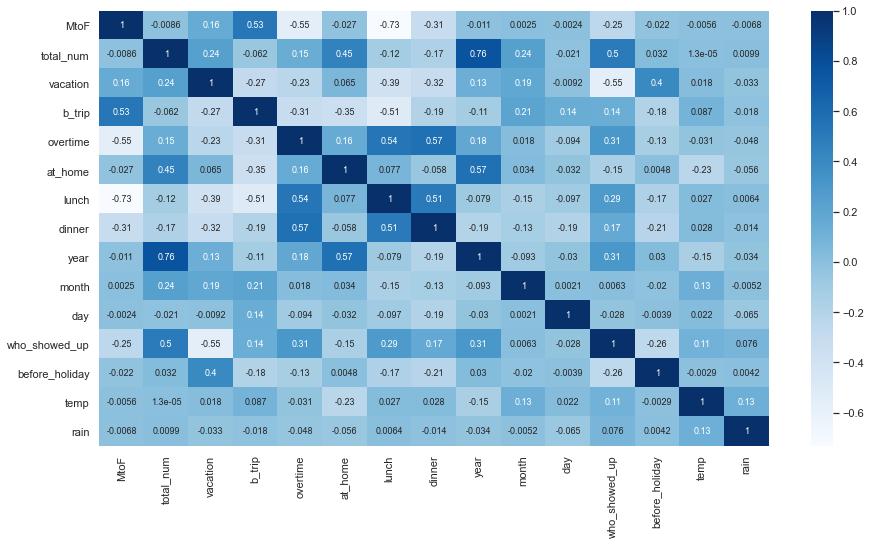

In [119]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(train_df.corr(),annot=True,annot_kws={"size":9}, cbar=True , cmap='Blues')


중식계, 석식계와 높은 상관관계를 보이는 변수


    -> 요일(MtoF)이 중식계와 -0.73이라는 큰 음의 상관관계를 보였습니다.
    -> overtime  중식계, 석식계 모두와 0.5가 넘는 양의 상관관계
    -> 기온과 강수량은 크게 상관관계 가지지 않는 것으로 보임

시각화

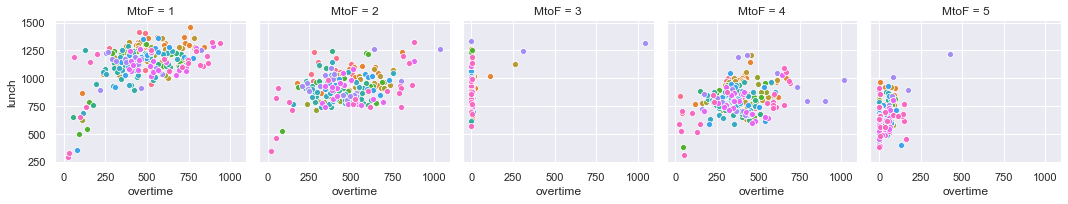

In [120]:
# 본사시간외근무명령서승인건수, 석식계, 중식계 시각화

grid = sns.FacetGrid(data=train_df, col='MtoF', hue = 'month')
grid.map(sns.scatterplot, 'overtime', 'lunch')

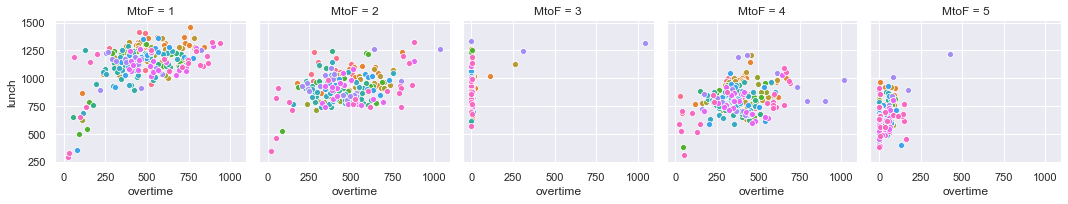

In [121]:
grid = sns.FacetGrid(data=train_df, col='MtoF', hue = 'month')
grid.map(sns.scatterplot, 'overtime', 'lunch')

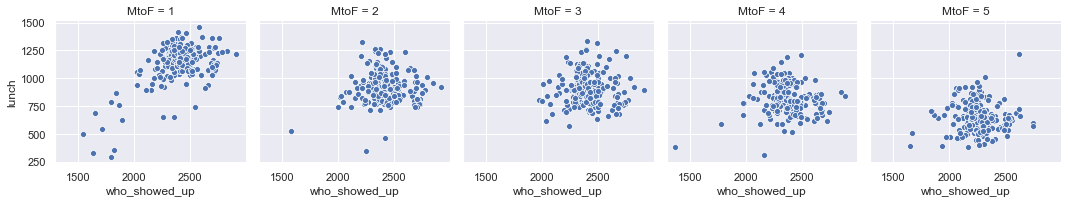

In [122]:
grid = sns.FacetGrid(data=train_df, col='MtoF')
grid.map(sns.scatterplot, 'who_showed_up', 'lunch')

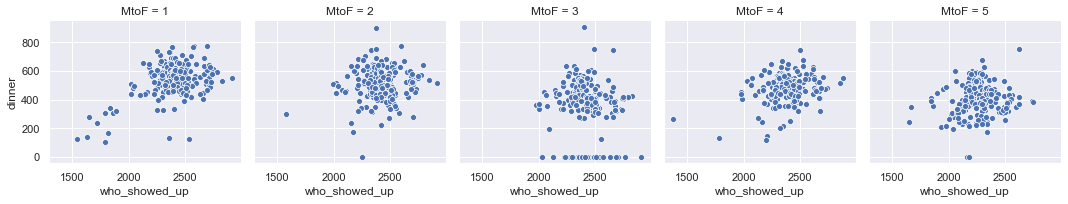

In [123]:
grid = sns.FacetGrid(data=train_df, col='MtoF')
grid.map(sns.scatterplot, 'who_showed_up', 'dinner')

## 꾸준한 양의 상관관계

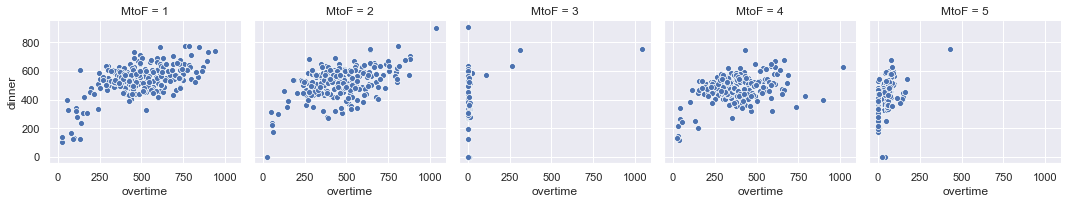

In [124]:
grid = sns.FacetGrid(data=train_df, col='MtoF')
grid.map(sns.scatterplot, 'overtime', 'dinner')

## 석식계는 야근자수와 상관관계 높음

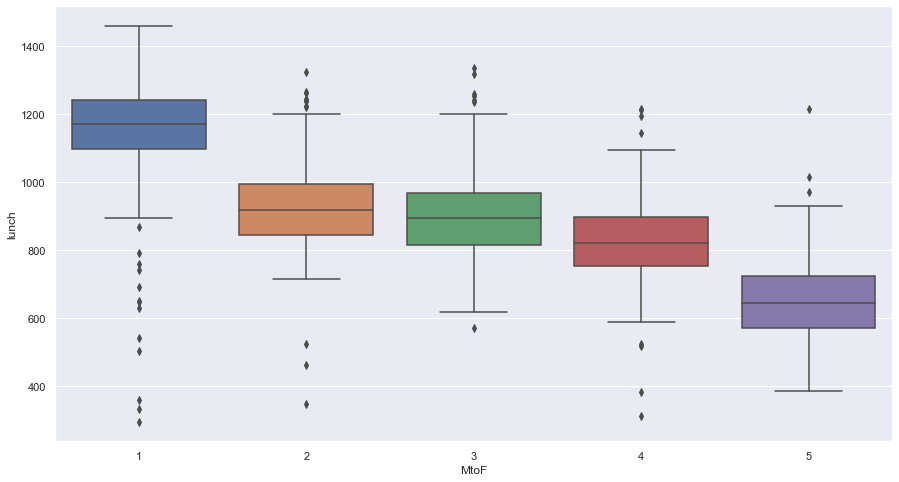

In [125]:
sns.boxplot(x="MtoF", 

            y="lunch", 

            data=train_df)

plt.show()



월요일이 제일 높고 그 이후로 하강세

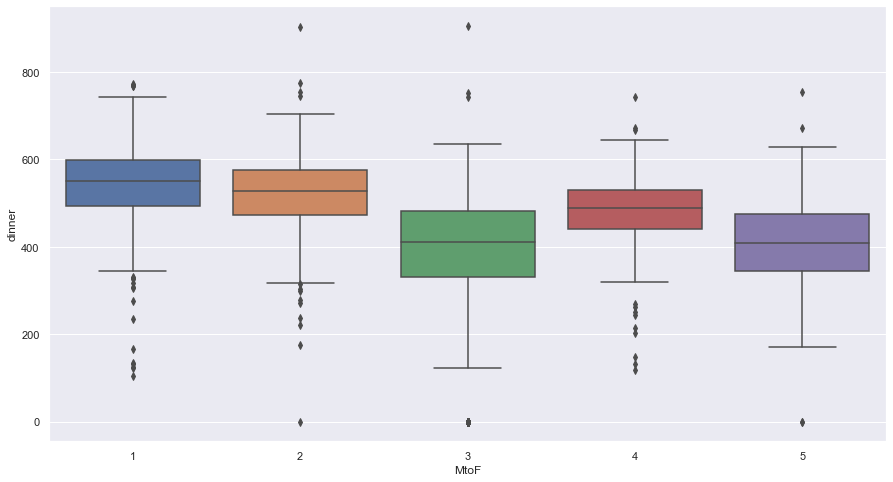

In [126]:
sns.boxplot(x="MtoF", 

            y="dinner", 

            data=train_df)

plt.show()


수요일은 자기계발의 날, 금요일은 정시퇴근자가 많아 석식계가 낮게 나옴을 알 수 있음

중식계는 출근자수와, 석식계는 야근자수와 높은 상관관계를 보임

# 모델링

LightGBM

In [127]:
train_df = pd.get_dummies(train_df,columns=['MtoF'] )

In [128]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_num       1205 non-null   int64  
 1   vacation        1205 non-null   int64  
 2   b_trip          1205 non-null   int64  
 3   overtime        1205 non-null   int64  
 4   at_home         1205 non-null   float64
 5   lunch           1205 non-null   float64
 6   dinner          1205 non-null   float64
 7   year            1205 non-null   int64  
 8   month           1205 non-null   int64  
 9   day             1205 non-null   int64  
 10  who_showed_up   1205 non-null   float64
 11  before_holiday  1205 non-null   int64  
 12  temp            1205 non-null   float64
 13  rain            1205 non-null   float64
 14  MtoF_1          1205 non-null   uint8  
 15  MtoF_2          1205 non-null   uint8  
 16  MtoF_3          1205 non-null   uint8  
 17  MtoF_4          1205 non-null   u

In [129]:
train = train_df[0:843]
test = train_df[844:]
train = train.replace(np.NaN,0)

In [130]:
test

,total_num,vacation,b_trip,overtime,at_home,lunch,dinner,year,month,day,who_showed_up,before_holiday,temp,rain,MtoF_1,MtoF_2,MtoF_3,MtoF_4,MtoF_5
844,2760,113,274,310,0.0,734.0,455.0,2019,7,18,2373.0,0,19.2,0.0,0,0,0,1,0
845,2760,236,291,0,0.0,538.0,367.0,2019,7,19,2233.0,0,19.9,0.0,0,0,0,0,1
846,2760,223,218,438,0.0,1013.0,503.0,2019,7,22,2319.0,0,20.3,0.0,1,0,0,0,0
847,2760,206,246,449,0.0,855.0,516.0,2019,7,23,2308.0,0,19.0,2.8,0,1,0,0,0
848,2760,224,252,0,0.0,744.0,322.0,2019,7,24,2284.0,0,21.9,0.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2983,75,198,4,391.0,1093.0,421.0,2021,1,20,2319.0,0,20.8,0.0,0,0,1,0,0
1201,2983,92,231,462,351.0,832.0,353.0,2021,1,21,2309.0,0,20.7,4.7,0,0,0,1,0
1202,2983,255,248,1,303.0,579.0,217.0,2021,1,22,2177.0,0,17.2,44.2,0,0,0,0,1
1203,2983,107,153,616,327.0,1145.0,502.0,2021,1,25,2396.0,0,18.6,15.7,1,0,0,0,0


In [131]:
x_lun = train.drop(['day','dinner','lunch','rain','temp'],axis=1)                 ## x_lun이나 x_din이나 같음 사실
y_lun = train['lunch']

x_din = train.drop(['day','dinner','lunch','rain','temp'],axis=1)
y_din = train['dinner']

test_pred = test.drop(['day','dinner','lunch','rain','temp'],axis=1)


In [132]:
x_lun

,total_num,vacation,b_trip,overtime,at_home,year,month,who_showed_up,before_holiday,MtoF_1,MtoF_2,MtoF_3,MtoF_4,MtoF_5
0,2601,50,150,238,0.0,2016,2,2401.0,0,1,0,0,0,0
1,2601,50,173,319,0.0,2016,2,2378.0,0,0,1,0,0,0
2,2601,56,180,111,0.0,2016,2,2365.0,0,0,0,1,0,0
3,2601,104,220,355,0.0,2016,2,2277.0,0,0,0,0,1,0
4,2601,278,181,34,0.0,2016,2,2142.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,2760,123,286,0,0.0,2019,7,2351.0,0,0,0,1,0,0
839,2760,102,301,371,0.0,2019,7,2357.0,0,0,0,0,1,0
840,2760,244,306,0,0.0,2019,7,2210.0,0,0,0,0,0,1
841,2760,144,232,396,0.0,2019,7,2384.0,0,1,0,0,0,0


In [133]:
test_pred.head()

,total_num,vacation,b_trip,overtime,at_home,year,month,who_showed_up,before_holiday,MtoF_1,MtoF_2,MtoF_3,MtoF_4,MtoF_5
844,2760,113,274,310,0.0,2019,7,2373.0,0,0,0,0,1,0
845,2760,236,291,0,0.0,2019,7,2233.0,0,0,0,0,0,1
846,2760,223,218,438,0.0,2019,7,2319.0,0,1,0,0,0,0
847,2760,206,246,449,0.0,2019,7,2308.0,0,0,1,0,0,0
848,2760,224,252,0,0.0,2019,7,2284.0,0,0,0,1,0,0


In [134]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model=GridSearchCV(model, param_grid=params, scoring='neg_mean_absolute_error', cv=5)
    grid_model.fit(X_feature, y_target)
    rmae=np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMAE: {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmae,4), grid_model.best_params_))

In [135]:
from lightgbm import LGBMRegressor

In [136]:
from sklearn.metrics import mean_absolute_error

In [137]:
x_train, x_test, y_train, y_test = train_test_split(x_lun,y_lun , test_size=0.3, random_state=42)

# 중식계
X_feature=x_train
y_target=y_train

lgbm_params = {'n_estimators':[1000]}
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMAE: 8.3048, 최적 alpha:{'n_estimators': 1000}


In [138]:
lgbm_reg.fit(x_train, y_train)
lgbm_pred=lgbm_reg.predict(x_test)

In [139]:
mean_absolute_error(y_test, lgbm_pred)

65.60909586623428

In [140]:
# 석식계


x_train, x_test, y_train, y_test = train_test_split(x_din, y_din , test_size=0.3, random_state=42)

X_features=x_train
y_target=y_train

lgbm_params={'n_estimators':[1000]}
lgbm_reg2=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.3, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg2, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMAE: 8.397, 최적 alpha:{'n_estimators': 1000}


In [141]:
lgbm_reg2.fit(x_train, y_train)
lgbm_pred2=lgbm_reg2.predict(x_test)

In [142]:
mean_absolute_error(y_test, lgbm_pred2)

63.24974833614277

Catboost

In [143]:
from catboost import CatBoostRegressor

In [144]:
cat=CatBoostRegressor()

In [145]:
# 중식계 

x_train, x_test, y_train, y_test =train_test_split(x_din, y_lun, test_size=0.3, random_state=42)

In [146]:
cat.fit(x_train, y_train)

Learning rate set to 0.037668
0:	learn: 199.0772270	total: 2.49ms	remaining: 2.49s
1:	learn: 194.7165768	total: 4.79ms	remaining: 2.39s
2:	learn: 190.4251531	total: 7.08ms	remaining: 2.35s
3:	learn: 186.1237539	total: 8.99ms	remaining: 2.24s
4:	learn: 182.1668878	total: 11ms	remaining: 2.18s
5:	learn: 178.1424053	total: 12.9ms	remaining: 2.14s
6:	learn: 174.3254285	total: 14.9ms	remaining: 2.11s
7:	learn: 170.7709285	total: 17.2ms	remaining: 2.14s
8:	learn: 167.6011154	total: 19.6ms	remaining: 2.16s
9:	learn: 164.3360169	total: 21.5ms	remaining: 2.13s
10:	learn: 161.4758621	total: 23.6ms	remaining: 2.13s
11:	learn: 158.2577909	total: 25.5ms	remaining: 2.1s
12:	learn: 155.3658858	total: 27.5ms	remaining: 2.08s
13:	learn: 152.4153101	total: 30.2ms	remaining: 2.13s
14:	learn: 149.9120117	total: 32.6ms	remaining: 2.14s
15:	learn: 147.0862646	total: 36.9ms	remaining: 2.27s
16:	learn: 144.5828947	total: 40.3ms	remaining: 2.33s
17:	learn: 142.1535542	total: 41.9ms	remaining: 2.29s
18:	learn: 

In [147]:
cat_pred=cat.predict(x_test)

In [148]:
mean_absolute_error(y_test,cat_pred)

65.34308947500158

In [149]:
# 석식계 

x_train, x_test, y_train, y_test =train_test_split(x_din, y_din, test_size=0.3, random_state=42)

In [150]:
cat2=CatBoostRegressor()

In [151]:
cat2.fit(x_train, y_train, verbose=False)

In [152]:
cat_pred2=cat2.predict(x_test)

In [153]:
mean_absolute_error(y_test,cat_pred2)

62.784308295175684

랜덤포레스트

In [154]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_jobs=-1, random_state=42,criterion='mae')
forest.fit(x_lun, y_lun)

RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=42)

In [156]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_jobs=-1, random_state=42,criterion='mae')
forest.fit(x_din, y_din)

RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=42)

In [ ]:
# sub.iloc[:,1] = forest.predict(test_pred)
# sub.iloc[:,2] = forest.predict(test_pred)